In [204]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np # linear algebra
import random as rd # random number generator
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [205]:
df = pd.read_csv('phishing-dataset/PhiUSIIL_Phishing_URL_Dataset.csv')

In [206]:
len(df)

235795

In [207]:
df.head(50)

,FILENAME,URL,URLLength,Domain,DomainLength,IsDomainIP,TLD,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,...,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
0,521848.txt,https://www.southbankmosaics.com,31,www.southbankmosaics.com,24,0,com,100.000000,1.000000,0.522907,...,0,0,1,34,20,28,119,0,124,1
1,31372.txt,https://www.uni-mainz.de,23,www.uni-mainz.de,16,0,de,100.000000,0.666667,0.032650,...,0,0,1,50,9,8,39,0,217,1
2,597387.txt,https://www.voicefmradio.co.uk,29,www.voicefmradio.co.uk,22,0,uk,100.000000,0.866667,0.028555,...,0,0,1,10,2,7,42,2,5,1
3,554095.txt,https://www.sfnmjournal.com,26,www.sfnmjournal.com,19,0,com,100.000000,1.000000,0.522907,...,1,1,1,3,27,15,22,1,31,1
4,151578.txt,https://www.rewildingargentina.org,33,www.rewildingargentina.org,26,0,org,100.000000,1.000000,0.079963,...,1,0,1,244,15,34,72,1,85,1
5,23107.txt,https://www.globalreporting.org,30,www.globalreporting.org,23,0,org,100.000000,1.000000,0.079963,...,0,0,1,35,1,11,86,0,14,1
6,23034.txt,https://www.saffronart.com,25,www.saffronart.com,18,0,com,100.000000,1.000000,0.522907,...,0,0,1,32,4,14,44,2,17,1
7,696732.txt,https://www.nerdscandy.com,25,www.nerdscandy.com,18,0,com,100.000000,1.000000,0.522907,...,0,0,1,24,2,22,36,0,15,1
8,739255.txt,https://www.hyderabadonline.in,29,www.hyderabadonline.in,22,0,in,100.000000,1.000000,0.005084,...,0,0,1,71,4,9,40,1,317,1
9,14486.txt,https://www.aap.org,18,www.aap.org,11,0,org,100.000000,1.000000,0.079963,...,0,0,1,10,1,12,173,6,65,1


In [208]:
# non-phishing sites
df[df['label'] == 1]

,FILENAME,URL,URLLength,Domain,DomainLength,IsDomainIP,TLD,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,...,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
0,521848.txt,https://www.southbankmosaics.com,31,www.southbankmosaics.com,24,0,com,100.0,1.000000,0.522907,...,0,0,1,34,20,28,119,0,124,1
1,31372.txt,https://www.uni-mainz.de,23,www.uni-mainz.de,16,0,de,100.0,0.666667,0.032650,...,0,0,1,50,9,8,39,0,217,1
2,597387.txt,https://www.voicefmradio.co.uk,29,www.voicefmradio.co.uk,22,0,uk,100.0,0.866667,0.028555,...,0,0,1,10,2,7,42,2,5,1
3,554095.txt,https://www.sfnmjournal.com,26,www.sfnmjournal.com,19,0,com,100.0,1.000000,0.522907,...,1,1,1,3,27,15,22,1,31,1
4,151578.txt,https://www.rewildingargentina.org,33,www.rewildingargentina.org,26,0,org,100.0,1.000000,0.079963,...,1,0,1,244,15,34,72,1,85,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235789,179093.txt,https://www.life-in-ecuador.com,30,www.life-in-ecuador.com,23,0,com,100.0,0.533333,0.522907,...,0,0,1,43,1,16,42,0,44,1
235790,660997.txt,https://www.skincareliving.com,29,www.skincareliving.com,22,0,com,100.0,1.000000,0.522907,...,1,0,1,51,7,21,187,2,191,1
235791,77185.txt,https://www.winchester.gov.uk,28,www.winchester.gov.uk,21,0,uk,100.0,0.785714,0.028555,...,1,0,0,50,1,7,88,0,31,1
235792,622132.txt,https://www.nononsensedesign.be,30,www.nononsensedesign.be,23,0,be,100.0,1.000000,0.003319,...,0,0,1,27,10,30,58,2,67,1


In [209]:
# phishing sites
df[df['label'] == 0]

,FILENAME,URL,URLLength,Domain,DomainLength,IsDomainIP,TLD,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,...,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
11,mw42508.txt,http://www.teramill.com,22,www.teramill.com,16,0,com,82.644628,1.000000,0.522907,...,0,0,0,0,0,0,0,0,1,0
20,mw16985.txt,http://www.f0519141.xsph.ru,26,www.f0519141.xsph.ru,20,0,ru,55.284926,0.923077,0.018013,...,0,0,0,0,0,0,0,0,0,0
21,mw131249.txt,http://www.shprakserf.gq,24,www.shprakserf.gq,17,0,gq,56.551141,1.000000,0.000053,...,0,0,0,0,0,0,0,0,0,0
27,7972389.txt,https://service-mitld.firebaseapp.com/,37,service-mitld.firebaseapp.com,29,0,com,64.645264,0.480000,0.522907,...,0,0,0,0,0,0,0,0,0,0
28,mw34096.txt,http://www.kuradox92.lima-city.de,32,www.kuradox92.lima-city.de,26,0,de,45.849802,0.526316,0.032650,...,0,0,0,1,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235780,8020762.txt,https://ww.prestamo.enlinea.pe.vpphoangha.vn/,44,ww.prestamo.enlinea.pe.vpphoangha.vn,36,0,vn,34.109109,0.333333,0.001363,...,0,0,0,0,0,0,0,0,0,0
235782,8091639.txt,http://goldenrod-motley-texture.glitch.me/hvwae.htm,51,goldenrod-motley-texture.glitch.me,34,0,me,27.796143,0.322581,0.003638,...,0,0,0,0,0,0,0,0,0,0
235783,8095159.txt,https://bancolombia.com1home0892.repl.co/?2,43,bancolombia.com1home0892.repl.co,32,0,co,47.074830,0.551724,0.005977,...,0,0,0,2,0,4,1,0,1,0
235784,8060468.txt,https://aol-108318.weeblysite.com/,34,aol-108318.weeblysite.com,25,0,com,66.720000,0.809524,0.522907,...,1,0,0,19,3,9,1,0,4,0


In [210]:
df['label'].describe()

count    235795.000000
mean          0.571895
std           0.494805
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: label, dtype: float64

In [211]:
df_cleaned = df.drop(columns='FILENAME')

In [212]:
def split_data(df_total, class_col, pos_label, neg_label, size):
    
    full_pos = df_total[df_total[class_col] == pos_label]
    full_neg = df_total[df_total[class_col] == neg_label]
    
    split_pos_index = round(len(full_pos) * size)
    split_neg_index = round(len(full_neg) * size)
    
    pos1 = full_pos.iloc[:split_pos_index]
    pos2 = full_pos.iloc[split_pos_index:]
    neg1 = full_neg.iloc[:split_neg_index]
    neg2 = full_neg.iloc[split_neg_index:]
    
    return pos1.reset_index(drop=True), pos2.reset_index(drop=True), neg1.reset_index(drop=True), neg2.reset_index(drop=True)

In [213]:
def get_random_indices(num_of_random,len_of_df):
    
    indices = []
    
    for i in range(num_of_random):
        indices.append(rd.randint(0,len_of_df-1))
    
    return indices

In [214]:
def create_train_test_set(pos1, pos2, neg1, neg2, feature_cols, class_col, num_of_rand):
    
    feature_cols = feature_cols.drop(class_col)
    
    random_nc = pd.DataFrame()
    X_train = pd.DataFrame()
    X_test = pd.DataFrame()
    y_train = pd.DataFrame()
    y_test = pd.DataFrame()
    
    random_pos_indices = get_random_indices(num_of_rand,len(pos1))
    random_pos = pos1.iloc[random_pos_indices]
    remaining_pos1 = pos1.drop(random_pos_indices)
    
    random_neg_indices = get_random_indices(num_of_rand,len(neg1))
    random_neg = neg1.iloc[random_neg_indices]
    remaining_neg1 = neg1.drop(random_neg_indices)
    
#     print("Len of indices" , len(random_neg_indices))
    
    full_train_set = pd.concat([random_pos,random_neg])
    
    full_remaining_pos = pd.concat([remaining_pos1,pos2])
    full_remaining_neg = pd.concat([remaining_neg1,neg2])
    full_test_set = pd.concat([full_remaining_pos,full_remaining_neg])
    
    X_train = full_train_set[feature_cols]
    y_train = pd.concat([y_train,full_train_set[class_col]])
    
    X_test = full_test_set[feature_cols]
    y_test = pd.concat([y_test,full_test_set[class_col]])
    
    return X_train.reset_index(drop=True), y_train.reset_index(drop=True), X_test.reset_index(drop=True), y_test.reset_index(drop=True)

In [215]:
df.dtypes

FILENAME                       object
URL                            object
URLLength                       int64
Domain                         object
DomainLength                    int64
IsDomainIP                      int64
TLD                            object
URLSimilarityIndex            float64
CharContinuationRate          float64
TLDLegitimateProb             float64
URLCharProb                   float64
TLDLength                       int64
NoOfSubDomain                   int64
HasObfuscation                  int64
NoOfObfuscatedChar              int64
ObfuscationRatio              float64
NoOfLettersInURL                int64
LetterRatioInURL              float64
NoOfDegitsInURL                 int64
DegitRatioInURL               float64
NoOfEqualsInURL                 int64
NoOfQMarkInURL                  int64
NoOfAmpersandInURL              int64
NoOfOtherSpecialCharsInURL      int64
SpacialCharRatioInURL         float64
IsHTTPS                         int64
LineOfCode  

In [216]:
corr_matrix = df.corr(numeric_only = True)
corr_matrix.style.background_gradient(cmap='coolwarm')

,URLLength,DomainLength,IsDomainIP,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,URLCharProb,TLDLength,NoOfSubDomain,HasObfuscation,NoOfObfuscatedChar,ObfuscationRatio,NoOfLettersInURL,LetterRatioInURL,NoOfDegitsInURL,DegitRatioInURL,NoOfEqualsInURL,NoOfQMarkInURL,NoOfAmpersandInURL,NoOfOtherSpecialCharsInURL,SpacialCharRatioInURL,IsHTTPS,LineOfCode,LargestLineLength,HasTitle,DomainTitleMatchScore,URLTitleMatchScore,HasFavicon,Robots,IsResponsive,NoOfURLRedirect,NoOfSelfRedirect,HasDescription,NoOfPopup,NoOfiFrame,HasExternalFormSubmit,HasSocialNet,HasSubmitButton,HasHiddenFields,HasPasswordField,Bank,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
URLLength,1.000000,0.243091,0.277272,-0.421104,-0.241104,-0.016656,-0.245215,0.033339,0.071058,0.161980,0.459094,0.127472,0.956047,0.312632,0.835809,0.304379,0.685091,0.474901,0.500387,0.782582,0.199112,0.013117,-0.060636,0.045219,-0.075456,-0.215877,-0.193234,-0.094548,-0.073770,-0.082549,0.029975,-0.005168,-0.149104,-0.010952,-0.044875,-0.035443,-0.180909,-0.067420,-0.072551,0.021561,-0.031734,-0.057816,-0.025163,-0.126420,-0.064639,-0.014507,-0.078643,-0.074722,-0.023206,-0.059055,-0.233445
DomainLength,0.243091,1.000000,-0.041398,-0.420694,-0.577425,0.027209,-0.178104,0.152669,0.399157,0.041643,0.011304,0.021627,0.277602,0.547854,0.131709,0.289628,0.020033,0.064477,0.016320,0.272930,0.182803,-0.019218,-0.075171,0.067131,-0.107133,-0.296493,-0.328603,-0.148317,-0.082594,-0.119737,0.019387,-0.046803,-0.202821,-0.012502,-0.051687,-0.038560,-0.216055,-0.111077,-0.111882,0.009409,-0.039944,-0.065895,-0.034773,-0.196860,-0.083458,-0.017596,-0.102216,-0.096712,-0.031673,-0.070099,-0.283152
IsDomainIP,0.277272,-0.041398,1.000000,-0.121439,-0.101307,-0.053220,-0.111769,-0.011125,0.084619,0.001239,0.000354,0.000977,0.244300,-0.002630,0.224703,0.161257,0.288351,0.389523,0.178814,0.285846,0.115484,-0.011741,-0.016211,0.002159,-0.004602,-0.052033,-0.054458,-0.030890,-0.028261,-0.006481,0.023497,-0.010231,-0.021518,-0.002795,-0.009741,-0.007988,-0.046432,-0.011489,-0.011962,-0.008419,-0.015708,-0.013863,-0.005919,-0.022796,-0.016502,-0.004149,-0.023126,-0.018981,-0.006793,-0.015269,-0.060202
URLSimilarityIndex,-0.421104,-0.420694,-0.121439,1.000000,0.572938,0.162042,0.571622,-0.053915,-0.058481,-0.100159,-0.032257,-0.078989,-0.449120,-0.491761,-0.299591,-0.561238,-0.161075,-0.341722,-0.075346,-0.540554,-0.604885,0.346389,0.231147,-0.078496,0.352123,0.604045,0.543969,0.402334,0.313293,0.433413,-0.060840,-0.049634,0.590195,0.041042,0.191208,0.139202,0.673690,0.448227,0.404655,0.061553,0.151290,0.291542,0.087228,0.613620,0.235728,0.057683,0.315679,0.271590,0.091556,0.221960,0.860358
CharContinuationRate,-0.241104,-0.577425,-0.101307,0.572938,1.000000,0.237221,0.349810,0.051438,-0.482314,-0.036231,-0.004371,-0.021257,-0.252761,-0.304448,-0.158497,-0.343880,-0.068517,-0.145347,-0.034872,-0.425542,-0.711020,0.089170,0.133351,-0.068861,0.164529,0.550943,0.568560,0.213020,0.177268,0.206705,-0.031916,0.019089,0.340722,0.021262,0.127151,0.086036,0.380694,0.245257,0.220213,0.075026,0.095809,0.179145,0.059667,0.345566,0.135931,0.027943,0.183900,0.147881,0.049963,0.121745,0.467735
TLDLegitimateProb,-0.016656,0.027209,-0.053220,0.162042,0.237221,1.000000,0.274224,0.386794,-0.250048,-0.016577,0.001207,-0.010993,-0.004864,0.128466,-0.029101,-0.090831,-0.009376,-0.036019,-0.011255,-0.094307,-0.280275,0.043764,0.041658,-0.025272,0.005597,0.298565,0.296253,0.033452,0.058150,0.081560,-0.008145,-0.036884,0.119061,0.005316,0.093219,0.027294,0.097843,0.063004,0.075440,0.070310,0.085441,0.111494,0.038673,0.114394,0.053432,0.008296,0.058475,0.028216,0.015252,0.033182,0.097389
URLCharProb,-0.245215,-0.178104,-0.111769,0.571622,0.349810,0.274224,1.000000,0.069818,-0.081576,-0.056108,-0.029030,-0.044623,-0.214701,0.045577,-0.290734,-0.708875,-0.103363,-0.193290,-0.055230,-0.307038,-0.396982,0.161159,0.124884,-0.058660,0.156942,0.361329,0.331182,0.216097,0.1

In [217]:
numeric_df = df.select_dtypes(exclude=object)

In [218]:
numeric_df.dtypes

URLLength                       int64
DomainLength                    int64
IsDomainIP                      int64
URLSimilarityIndex            float64
CharContinuationRate          float64
TLDLegitimateProb             float64
URLCharProb                   float64
TLDLength                       int64
NoOfSubDomain                   int64
HasObfuscation                  int64
NoOfObfuscatedChar              int64
ObfuscationRatio              float64
NoOfLettersInURL                int64
LetterRatioInURL              float64
NoOfDegitsInURL                 int64
DegitRatioInURL               float64
NoOfEqualsInURL                 int64
NoOfQMarkInURL                  int64
NoOfAmpersandInURL              int64
NoOfOtherSpecialCharsInURL      int64
SpacialCharRatioInURL         float64
IsHTTPS                         int64
LineOfCode                      int64
LargestLineLength               int64
HasTitle                        int64
DomainTitleMatchScore         float64
URLTitleMatc

In [219]:
# sim_len = 1
# class_col = 'label'
# pos_label = 0
# neg_label = 1
# size = .5
# X_train, y_train, X_test, y_test = run_simulation(sim_len, numeric_df, class_col, pos_label, neg_label, size)

In [220]:
# col_names = X_train.columns.values.tolist()
# label = y_train.columns.values.tolist()

# print("Cols", col_names)
# print("Label", label)

In [221]:
# clf = DecisionTreeClassifier(criterion='entropy') # Initialize the decision tree classifier
# clf.fit(X_train, y_train) # Fitting the classifier on the training data

# col_names = X_train.columns
# label = y_train.columns[0]
# plot_tree(clf)

# # print("Cols", feature_names)
# # print("Label", label)
# # dot_data = tree.export_graphviz(clf, out_file=None) 
# # graph = graphviz.Source(dot_data) 
# # graph.render("Phishing")
# # dot_data = tree.export_graphviz(clf, out_file=None,
# #                                 feature_names=col_names,  
# #                                 class_names=label,  
# #                                 filled=True, rounded=True,  
# #                                 special_characters=True) 
# # graph = graphviz.Source(dot_data)  
# # graph


In [222]:
def get_entropy(info):
    
    text = str(info)
    
    parts = text.split('entropy = ')[1]
    entropy_value = parts.split('\\n')[0]

    # Convert the entropy value to a float
    return float(entropy_value)

In [223]:
def get_num_of_samples(info):
    
    text = str(info)
    
    parts = text.split('samples = ')[1]
    sample_value = parts.split('\\n')[0]

    # Convert the entropy value to a float
    return float(sample_value)

In [224]:
from sklearn import tree
def model_metrics(X_train, y_train):
    
    clf = DecisionTreeClassifier(criterion='entropy', max_depth=1) # Initialize the decision tree classifier
    clf.fit(X_train, y_train) # Fitting the classifier on the training data
    
    col_names = X_train.columns
    label = y_train.columns[0]
    
    info = plot_tree(clf, feature_names=col_names, class_names=[str(pos_label), str(neg_label)], rounded=True, filled=True)
    
    metrics = {
        'Graph' : info,
        'Tree': clf,
        'e_parent': get_entropy(info[0]),
        'e_child1': get_entropy(info[1]),
        'e_child2' : get_entropy(info[3]),
        'parent_sample' : get_num_of_samples(info[0]),
        'child_sample1' : get_num_of_samples(info[1]),
        'child_sample2' : get_num_of_samples(info[3]),
    }

#     plot_tree(clf, feature_names=col_names, class_names=[str(pos_label), str(neg_label)], rounded=True, filled=True)
#     plt.show()
    
    return metrics

In [225]:
def calculate_information_gain(metrics):
    
    return metrics['e_parent']-((metrics['child_sample1']/metrics['parent_sample'])*metrics['e_child1'])-((metrics['child_sample2']/metrics['parent_sample'])*metrics['e_child2'])

In [226]:
def get_information_gain(X_train, y_train, label_col, columns):
    
    information_gain_weights = pd.DataFrame()
    col_names = columns[:-1]
    current_information_gain = np.array([])

    
    for col in columns:
        if col != label_col:
            metrics = model_metrics(X_train[[col]], y_train)
            current_information_gain = np.append(current_information_gain, calculate_information_gain(metrics))
    current_information_gain = current_information_gain.reshape(1,-1)
    information_gain_weights = pd.DataFrame(current_information_gain, columns=col_names)

    return information_gain_weights

        

In [227]:
def get_avg_info_gain_df(df_gain):
    # Compute the mean of each column in the DataFrame
    avg_info_gain = df_gain.mean()
    
    # Convert the resulting Series to a NumPy array
    avg_info_gain_array = avg_info_gain.to_numpy()
    
    # Create a DataFrame from the average coefficients
    avg_info_gain_df = pd.DataFrame([avg_info_gain], columns=df_gain.columns, index=['avg'])
    
    # Concatenate the original DataFrame with the average coefficients DataFrame
    result_df = pd.concat([df_gain, avg_info_gain_df], ignore_index=False)
    
    return result_df, avg_info_gain_array

In [228]:
def run_simulation(sim_len, df_total, label_col,pos_label, neg_label, size, num_of_rand):
    
    sim_info_gain = pd.DataFrame()
    
    phishing1, phishing2, non_phishing1, non_phishing2 = split_data(df_total, label_col, pos_label, neg_label, size)
    
    for i in range(sim_len):
        
        X_train, y_train, X_test, y_test = create_train_test_set(phishing1, phishing2, non_phishing1, non_phishing2, df_total.columns, label_col, num_of_rand) 
        
        info_gain = get_information_gain(X_train, y_train, label_col, df_total.columns)
        
        sim_info_gain = pd.concat([info_gain, sim_info_gain])
        
    avg_info_gain_df, avg_info_gain_array = get_avg_info_gain_df(sim_info_gain)
        
    return avg_info_gain_df, avg_info_gain_array, X_test, y_test, X_train, y_train
    

In [229]:
def mod_run_simulation(sim_len, df_total, label_col,pos_label, neg_label, size, num_of_rand):

    sim_explained_variance = pd.DataFrame()
    
    pca = PCA(n_components=13)
    pc = pca.fit_transform(df_heart_standardized.iloc[:-1])

    df_pca = pd.DataFrame(data=pc, columns=['principal component 1', 'principal component 2', 'principal component 3',
                                        'principal component 4', 'principal component 5', 'principal component 6',
                                        'principal component 7','principal component 8','principal component 9','principal component 10','principal component 11','principal component 12','principal component 13'])

    final_pca_df = pd.concat([df_pca, df_heart_standardized[['num']]], axis = 1)

    phishing1, phishing2, non_phishing1, non_phishing2 = split_data(final_pca_df, label_col, pos_label, neg_label, size)

    for i in range(sim_len):

        X_train, y_train, X_test, y_test = create_train_test_set(phishing1, phishing2, non_phishing1, non_phishing2, final_pca_df.columns, label_col, num_of_rand)

        explained_variance = get_explained_variance(pca,df_pca.columns)
        
        print(explained_variance)
        sim_explained_variance = pd.concat([explained_variance, sim_explained_variance])
    

    avg_explained_variance_df, avg_explained_variance_array = get_avg_explained_variance_df(sim_explained_variance)

    return avg_explained_variance_df, avg_explained_variance_array, X_test, y_test, X_train, y_train


In [230]:
def get_explained_variance(pca,feature_cols):
    
    explained_variance= pca.explained_variance_ratio_
    explained_variance = explained_variance.reshape(1,-1)

    ev_df = pd.DataFrame(explained_variance, columns=feature_cols)
    
    return ev_df



In [231]:
def get_avg_explained_variance_df(df_ev):
    # Compute the mean of each column in the DataFrame
    avg_ev = df_ev.mean()

    # Convert the resulting Series to a NumPy array
    avg_ev_array = avg_ev.to_numpy()

    # Create a DataFrame from the average coefficients
    avg_ev_df = pd.DataFrame([avg_ev], columns=df_ev.columns, index=['avg'])

    # Concatenate the original DataFrame with the average coefficients DataFrame
    result_df = pd.concat([df_ev, avg_ev_df], ignore_index=False)

    return result_df, avg_ev_array

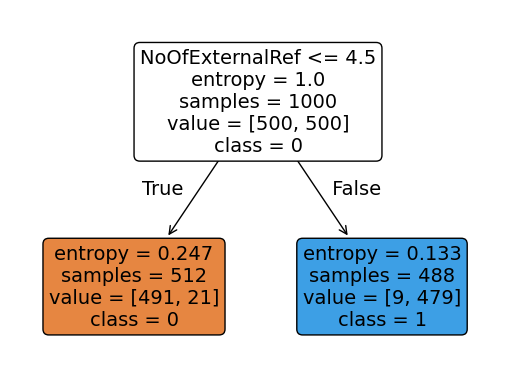

In [232]:
sim_len = 2
label_col = 'label'
pos_label = 0
neg_label = 1
size = .5
num_of_rand = 500
avg_info_gain_df, avg_info_gain_array, X_test, y_test,X_train, hy_train= run_simulation(sim_len, numeric_df, label_col, pos_label, neg_label, size, num_of_rand)


In [233]:
avg_info_gain_df

,URLLength,DomainLength,IsDomainIP,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,URLCharProb,TLDLength,NoOfSubDomain,HasObfuscation,...,Bank,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef
0,0.181188,0.087456,0.001,0.966232,0.147036,0.074900,0.125781,0.027376,0.058832,0.002,...,0.044195,0.098639,0.007296,0.501092,0.756083,0.590420,0.626772,0.7471,0.239375,0.808632
0,0.218698,0.102454,0.005,0.966232,0.161506,0.095529,0.132536,0.027578,0.054894,0.002,...,0.022950,0.096292,0.004368,0.484326,0.685424,0.547568,0.613112,0.7735,0.257172,0.759650
avg,0.199943,0.094955,0.003,0.966232,0.154271,0.085215,0.129159,0.027477,0.056863,0.002,...,0.033573,0.097465,0.005832,0.492709,0.720754,0.568994,0.619942,0.7603,0.248273,0.784141


In [234]:
alpha = .316
count = 0
swagger = []
indices = []  # Array to store the indices

for idx, ig in enumerate(avg_info_gain_array):
    
    if (((ig / .96) **2) < alpha):
        count += 1
        indices.append(idx)
    else: 
        swagger.append(ig)
print(f"Number of IG lower than {alpha:.6f}: {count:.2f}")

Number of IG lower than 0.316000: 42.00


In [235]:
print(swagger)

[np.float64(0.966232), np.float64(0.7738295), np.float64(0.5935714999999999), np.float64(0.7207535), np.float64(0.568994), np.float64(0.619942), np.float64(0.7603), np.float64(0.784141)]


In [236]:
column_names = [
  'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 
  'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'
]

df_heart = pd.read_csv('heartdiseaes/processed.cleveland.data', names = column_names, index_col = False)

new_row_values = [63, 1, 1, 145, 233, 1, 2, 150, 0, 2.3, 3.0, 0, 6.0, 0]

df_heart.loc[0] = new_row_values

In [237]:
for i in df_heart.itertuples():
    tup = i
    for j in tup:
        if j == '?':
            print(tup)

Pandas(Index=87, age=53.0, sex=0.0, cp=3.0, trestbps=128.0, chol=216.0, fbs=0.0, restecg=2.0, thalach=115.0, exang=0.0, oldpeak=0.0, slope=1.0, ca='0.0', thal='?', num=0)
Pandas(Index=166, age=52.0, sex=1.0, cp=3.0, trestbps=138.0, chol=223.0, fbs=0.0, restecg=0.0, thalach=169.0, exang=0.0, oldpeak=0.0, slope=1.0, ca='?', thal='3.0', num=0)
Pandas(Index=192, age=43.0, sex=1.0, cp=4.0, trestbps=132.0, chol=247.0, fbs=1.0, restecg=2.0, thalach=143.0, exang=1.0, oldpeak=0.1, slope=2.0, ca='?', thal='7.0', num=1)
Pandas(Index=266, age=52.0, sex=1.0, cp=4.0, trestbps=128.0, chol=204.0, fbs=1.0, restecg=0.0, thalach=156.0, exang=1.0, oldpeak=1.0, slope=2.0, ca='0.0', thal='?', num=2)
Pandas(Index=287, age=58.0, sex=1.0, cp=2.0, trestbps=125.0, chol=220.0, fbs=0.0, restecg=0.0, thalach=144.0, exang=0.0, oldpeak=0.4, slope=2.0, ca='?', thal='7.0', num=0)
Pandas(Index=302, age=38.0, sex=1.0, cp=3.0, trestbps=138.0, chol=175.0, fbs=0.0, restecg=0.0, thalach=173.0, exang=0.0, oldpeak=0.0, slope=1

In [238]:
row_nums = [87,166,192,266,287,302]
df_heart = df_heart.drop(row_nums)

In [239]:
df_heart.dtypes

age         float64
sex         float64
cp          float64
trestbps    float64
chol        float64
fbs         float64
restecg     float64
thalach     float64
exang       float64
oldpeak     float64
slope       float64
ca           object
thal         object
num           int64
dtype: object

In [240]:
df_heart['ca'] = pd.to_numeric(df_heart['ca'])

In [241]:
df_heart['thal'] = pd.to_numeric(df_heart['thal'])

In [242]:
df_heart['num'] = df_heart['num'].replace([1,2,3,4], 1)

In [243]:
def standardizer(df):
    
    temp_df = df.copy()
    
    for col in temp_df.columns[:-1]:
        
        temp_df[col] = (temp_df[col] - temp_df[col].mean())/temp_df[col].std()
        
    return temp_df

In [244]:
df_heart_standardized = standardizer(df_heart)

In [245]:
df_heart.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [246]:
df_heart_standardized.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,0.934603,0.689930,-2.236854,0.749116,-0.275978,2.426332,1.008496,0.017465,-0.695246,1.067164,2.260330,-0.720760,0.654772,0
1,1.376605,0.689930,0.872408,1.593577,0.743301,-0.410757,1.008496,-1.813274,1.433497,0.381130,0.642696,2.474249,-0.892713,1
2,1.376605,0.689930,0.872408,-0.658320,-0.352904,-0.410757,1.008496,-0.897904,1.433497,1.324427,0.642696,1.409246,1.170601,1
3,-1.938409,0.689930,-0.164013,-0.095345,0.050961,-0.410757,-1.001728,1.630258,-0.695246,2.096215,2.260330,-0.720760,-0.892713,0
4,-1.496407,-1.444542,-1.200433,-0.095345,-0.833696,-0.410757,1.008496,0.976423,-0.695246,0.295376,-0.974938,-0.720760,-0.892713,0


In [247]:
# sim_len = 100
# label_col = 'num'
# pos_label = 1
# neg_label = 0
# size = .5
# num_of_rand = 100
# heart_avg_info_gain_df, heart_avg_info_gain_array, heart_X_test, heart_y_test, heart_X_train, heart_y_train = run_simulation(sim_len, df_heart_standardized, label_col, pos_label, neg_label, size, num_of_rand)

In [248]:
# heart_avg_info_gain_df

In [249]:
# heart_avg_info_gain_array

In [250]:
# alpha = .1
# count = 0
# heart_swagger = []
# heart_indices = []  # Array to store the indices

# for idx, ig in enumerate(heart_avg_info_gain_array):
#     if ((ig / .34) ** 2 < alpha):
#         count += 1
#         heart_indices.append(idx)  # Append the index
#     else: 
#         heart_swagger.append(ig)
# print(f"Number of IG lower than {alpha:.6f}: {count:.2f}")

<p>1st process is getting sqaured difference </p>
<p>2nd weights dot squared diff </p>
<p>3rd sort resulting list</p>
<p>4th return k neighbors </p>
<p> 5th classify</p>

In [251]:
#a and b are rows here. 
def Euclid_Distance(a,b,weights,Columns,Class):
    c=Columns 
    D=0
    for i in range(len(c)-1):
        if c[i]!=Class:
            D+=(weights[i]**2)*(float(a[c[i]])-float(b[c[i]]))**2
    return D**0.5


def Nearest_Neighbors(point,List_Pot_Nbrs,weights,Class_Col_Name):
    ClassWithDistance=[]
    d=0
    for n in range(len(List_Pot_Nbrs)):
        d=Euclid_Distance(point,List_Pot_Nbrs.iloc[n],weights,List_Pot_Nbrs.columns,Class_Col_Name)
        ClassWithDistance+=[[d,List_Pot_Nbrs.iloc[n][Class_Col_Name]]]
    sorted_list = sorted(ClassWithDistance, key=lambda x: x[0])
    
    return sorted_list

def KNN(k,Sorted_List):
    Sum=0
    for i in range(k):
        if Sorted_List[i][1]==1:
            Sum+=1
    if Sum>k/2:
        return 1
    else:
        return 0
    
def ConfusionMatrix(TrP,TrN,FaP,FaN):
    print("         Confusion Matrix")
    print("TN,FP: ",TrN, "    ,    ", FaP)
    print("FN,TP: ",FaN,"     ,    ", TrP)


   principal component 1  principal component 2  principal component 3  \
0               0.241697               0.121318               0.094449   

   principal component 4  principal component 5  principal component 6  \
0               0.084116               0.075225                0.06577   

   principal component 7  principal component 8  principal component 9  \
0               0.064023               0.058954               0.051923   

   principal component 10  principal component 11  principal component 12  \
0                 0.04294                0.033978                0.030987   

   principal component 13  
0                0.026543  
   principal component 1  principal component 2  principal component 3  \
0               0.241697               0.121318               0.094449   

   principal component 4  principal component 5  principal component 6  \
0               0.084116               0.075225                0.06577   

   principal component 7  principal componen

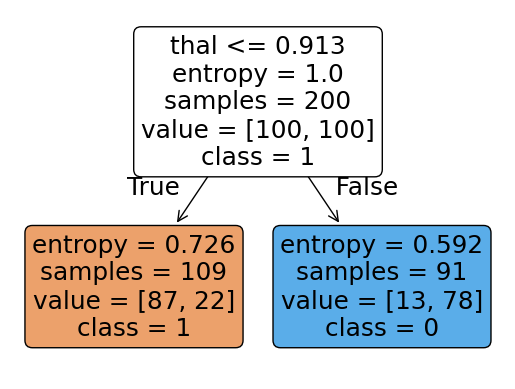

In [252]:
avg_acc = []
avg_precision = []
avg_recall = []
avg_f1 = []
avg_specificity = []

weight_avg_acc = []
weight_avg_precision = []
weight_avg_recall = []
weight_avg_f1 = []
weight_avg_specificity = []

dropped_weight_avg_acc = []
dropped_weight_avg_precision = []
dropped_weight_avg_recall = []
dropped_weight_avg_f1 = []
dropped_weight_avg_specificity = []

pca_avg_acc = []
pca_avg_precision = []
pca_avg_recall = []
pca_avg_f1 = []
pca_avg_specificity = []

pca_explained_variance_acc = []
pca_explained_variance_precision = []
pca_explained_variance_recall = []
pca_explained_variance_f1 = []
pca_explained_variance_specificity = []

sim_len = 50
label_col = 'num'
pos_label = 1
neg_label = 0
size = .5
num_of_rand = 100

for i in range(sim_len):
    
    
    heart_avg_info_gain_df, heart_avg_info_gain_array, heart_X_test, heart_y_test, heart_X_train, heart_y_train = run_simulation(sim_len, df_heart_standardized, label_col, pos_label, neg_label, size, num_of_rand)
    Train_Data =  pd.concat([heart_X_train, heart_y_train], axis=1)
    Test_Data = pd.concat([heart_X_test, heart_y_test], axis=1)
    
    TP=0
    TN=0
    FP=0
    FN=0


    for p in range(len(Test_Data)):
        point=Test_Data.iloc[p]
        NBRS=Nearest_Neighbors(point, Train_Data, [1,1,1,1,1,1,1,1,1,1,1,1,1], "num")
        Label=KNN(3,NBRS)
        if (Label==point["num"] and Label==1):
            TP+=1
        if (Label==point["num"] and Label==0):
            TN+=1
        if (Label!=point["num"] and Label==1):
            FP+=1
        if (Label!=point["num"] and Label==0):
            FN+=1
    A_non_weighted=(TP+TN)/(TP+TN+FP+FN)
    precision_non_weighted = TP/(TP+FP)
    recall_non_weighted = TP/(TP+FN)
    f1_non_weighted = (2 * precision_non_weighted * recall_non_weighted)/(precision_non_weighted+recall_non_weighted)
    specificity_non_weighted = TN/(TN+FP)
    
    
#     print("Accurecy:", A)
#     ConfusionMatrix(TP,TN,FP,FN)
    avg_acc.append(A_non_weighted*100)
    avg_precision.append(precision_non_weighted*100)
    avg_recall.append(recall_non_weighted*100)
    avg_f1.append(f1_non_weighted*100)
    avg_specificity.append(specificity_non_weighted*100)

    TP=0
    TN=0
    FP=0
    FN=0


    for p in range(len(Test_Data)):
        point=Test_Data.iloc[p]
        NBRS=Nearest_Neighbors(point, Train_Data,  heart_avg_info_gain_array, "num")
        Label=KNN(3,NBRS)
        if (Label==point["num"] and Label==1):
            TP+=1
        if (Label==point["num"] and Label==0):
            TN+=1
        if (Label!=point["num"] and Label==1):
            FP+=1
        if (Label!=point["num"] and Label==0):
            FN+=1
    A_weighted=(TP+TN)/(TP+TN+FP+FN)
    precision_weighted = TP/(TP+FP)
    recall_weighted = TP/(TP+FN)
    f1_weighted = (2 * precision_weighted * recall_weighted)/(precision_weighted+recall_weighted)
    specificity_weighted = TN/(TN+FP)

    weight_avg_acc.append(A_weighted*100)
    weight_avg_precision.append(precision_weighted*100)
    weight_avg_recall.append(recall_weighted*100)
    weight_avg_f1.append(f1_weighted*100)
    weight_avg_specificity.append(specificity_weighted*100)
    

    alpha = .1
    count = 0
    heart_swagger = []
    heart_indices = []  # Array to store the indices

    for idx, ig in enumerate(heart_avg_info_gain_array):
        if ((ig / .34) ** 2 < alpha):
            count += 1
            heart_indices.append(idx)  # Append the index
        else:
            heart_swagger.append(ig)

    dropped_heart_X_train = heart_X_train.drop(heart_X_train.columns[heart_indices],axis=1)
    dropped_heart_X_test = heart_X_train.drop(heart_X_test.columns[heart_indices],axis=1)

    Train_Data =  pd.concat([dropped_heart_X_train, heart_y_train], axis=1)
    Test_Data = pd.concat([dropped_heart_X_test, heart_y_test], axis=1)

    TP=0
    TN=0
    FP=0
    FN=0


    for p in range(len(Test_Data)):
        point=Test_Data.iloc[p]
        NBRS=Nearest_Neighbors(point, Train_Data, heart_swagger , "num")
        Label=KNN(3,NBRS)
        if (Label==point["num"] and Label==1):
            TP+=1
        if (Label==point["num"] and Label==0):
            TN+=1
        if (Label!=point["num"] and Label==1):
            FP+=1
        if (Label!=point["num"] and Label==0):
            FN+=1
    A_dropped_weighted=(TP+TN)/(TP+TN+FP+FN)
    precision_dropped_weighted = TP/(TP+FP)
    recall_dropped_weighted = TP/(TP+FN)
    f1_dropped_weighted = (2 * precision_dropped_weighted * recall_dropped_weighted)/(precision_dropped_weighted+recall_dropped_weighted)
    specificity_dropped_weighted = TN/(TN+FP)

    dropped_weight_avg_acc.append(A_dropped_weighted*100)
    dropped_weight_avg_precision.append(precision_dropped_weighted*100)
    dropped_weight_avg_recall.append(recall_dropped_weighted*100)
    dropped_weight_avg_f1.append(f1_dropped_weighted*100)
    dropped_weight_avg_specificity.append(specificity_dropped_weighted*100)

    pca = PCA(n_components=7)
    pc = pca.fit_transform(heart_X_train)
    pca2 = PCA(n_components=7)
    pc2 = pca.fit_transform(heart_X_test)

    df_pca = pd.DataFrame(data=pc, columns=['principal component 1', 'principal component 2', 'principal component 3',
                                            'principal component 4', 'principal component 5', 'principal component 6',
                                            'principal component 7'])
    df_pca2 = pd.DataFrame(data=pc2, columns=['principal component 1', 'principal component 2', 'principal component 3',
                                          'principal component 4', 'principal component 5', 'principal component 6',
                                          'principal component 7'])

    final_train_pca_df = pd.concat([df_pca, heart_y_train[['num']]], axis = 1)
    final_test_pca_df = pd.concat([df_pca2, heart_y_train[['num']]], axis = 1)

    Train_Data =  final_train_pca_df
    Test_Data = final_test_pca_df

    TP=0
    TN=0
    FP=0
    FN=0


    for p in range(len(Test_Data)):
        point=Test_Data.iloc[p]
        NBRS=Nearest_Neighbors(point, Train_Data, [1,1,1,1,1,1,1,1,1,1,1,1,1] , "num")
        Label=KNN(3,NBRS)
        if (Label==point["num"] and Label==1):
            TP+=1
        if (Label==point["num"] and Label==0):
            TN+=1
        if (Label!=point["num"] and Label==1):
            FP+=1
        if (Label!=point["num"] and Label==0):
            FN+=1
    
    A_pca=(TP+TN)/(TP+TN+FP+FN)
    precision_pca = TP/(TP+FP)
    recall_pca = TP/(TP+FN)
    f1_pca = (2 * precision_pca * recall_pca)/(precision_pca+recall_pca)
    specificity_pca = TN/(TN+FP)

    pca_avg_acc.append(A_pca*100)
    pca_avg_precision.append(precision_pca*100)
    pca_avg_recall.append(recall_pca*100)
    pca_avg_f1.append(f1_pca*100)
    pca_avg_specificity.append(specificity_pca*100)
    

    ev_heart_avg_ev_df, ev_heart_avg_ev_array, ev_heart_X_test, ev_heart_y_test, ev_heart_X_train, ev_heart_y_train = mod_run_simulation(sim_len, df_heart_standardized, label_col, pos_label, neg_label, size, num_of_rand)


    alpha = .1
    count = 0
    ev_heart_swagger = []
    ev_heart_indices = []  # Array to store the indices

    for idx, ev in enumerate(ev_heart_avg_ev_array):
        if (ev < (alpha**1/2)*max(ev_heart_avg_ev_array)):
            count += 1
            ev_heart_indices.append(idx)  # Append the index
        else:
            ev_heart_swagger.append(ev)

    ev_dropped_heart_X_train = ev_heart_X_train.drop(ev_heart_X_train.columns[ev_heart_indices],axis=1)
    ev_dropped_heart_X_test = ev_heart_X_train.drop(ev_heart_X_test.columns[ev_heart_indices],axis=1)

    Train_Data =  pd.concat([ev_dropped_heart_X_train, ev_heart_y_train], axis=1)
    Test_Data = pd.concat([ev_dropped_heart_X_test, ev_heart_y_test], axis=1)

    TP=0
    TN=0
    FP=0
    FN=0


    for p in range(len(Test_Data)):
        point=Test_Data.iloc[p]
        NBRS=Nearest_Neighbors(point, Train_Data, ev_heart_swagger , "num")
        Label=KNN(3,NBRS)
        if (Label==point["num"] and Label==1):
            TP+=1
        if (Label==point["num"] and Label==0):
            TN+=1
        if (Label!=point["num"] and Label==1):
            FP+=1
        if (Label!=point["num"] and Label==0):
            FN+=1
    A_pca_ev=(TP+TN)/(TP+TN+FP+FN)
    precision_pca_ev = TP/(TP+FP)
    recall_pca_ev = TP/(TP+FN)
    f1_pca_ev = (2 * precision_pca_ev * recall_pca_ev)/(precision_pca_ev+recall_pca_ev)
    specificity_pca_ev = TN/(TN+FP)

    pca_explained_variance_acc.append(A_pca*100)
    pca_explained_variance_precision.append(precision_pca*100)
    pca_explained_variance_recall.append(recall_pca*100)
    pca_explained_variance_f1.append(f1_pca*100)
    pca_explained_variance_specificity.append(specificity_pca*100)
    
    

<h1 style="text-align:center;"> Womp Womp our k-NN Only</h1>

In [283]:
for i in range(sim_len):
    alpha = .1
    count = 0
    heart_swagger = []
    heart_indices = []  # Array to store the indices
    
    for idx, ig in enumerate(heart_avg_info_gain_array):
        if ((ig / .34) ** 2 < alpha):
            count += 1
            heart_indices.append(idx)  # Append the index
        else:
            heart_swagger.append(ig)
    
    dropped_heart_X_train = heart_X_train.drop(heart_X_train.columns[heart_indices],axis=1)
    dropped_heart_X_test = heart_X_train.drop(heart_X_test.columns[heart_indices],axis=1)
    
    Train_Data =  pd.concat([dropped_heart_X_train, heart_y_train], axis=1)
    Test_Data = pd.concat([dropped_heart_X_test, heart_y_test], axis=1)
    
    TP=0
    TN=0
    FP=0
    FN=0
    
    
    for p in range(len(Test_Data)):
        point=Test_Data.iloc[p]
        NBRS=Nearest_Neighbors(point, Train_Data, heart_swagger , "num")
        Label=KNN(3,NBRS)
        if (Label==point["num"] and Label==1):
            TP+=1
        if (Label==point["num"] and Label==0):
            TN+=1
        if (Label!=point["num"] and Label==1):
            FP+=1
        if (Label!=point["num"] and Label==0):
            FN+=1
    A_dropped_weighted=(TP+TN)/(TP+TN+FP+FN)
    precision_dropped_weighted = TP/(TP+FP)
    recall_dropped_weighted = TP/(TP+FN)
    f1_dropped_weighted = (2 * precision_dropped_weighted * recall_dropped_weighted)/(precision_dropped_weighted+recall_dropped_weighted)
    specificity_dropped_weighted = TN/(TN+FP)
    
    dropped_weight_avg_acc.append(A_dropped_weighted*100)
    dropped_weight_avg_precision.append(precision_dropped_weighted*100)
    dropped_weight_avg_recall.append(recall_dropped_weighted*100)
    dropped_weight_avg_f1.append(f1_dropped_weighted*100)
    dropped_weight_avg_specificity.append(specificity_dropped_weighted*100)

In [253]:
pca = PCA(n_components=13)
pc = pca.fit_transform(df_heart_standardized.iloc[:-1])

df_pca = pd.DataFrame(data=pc, columns=['principal component 1', 'principal component 2', 'principal component 3',
                                        'principal component 4', 'principal component 5', 'principal component 6',
                                        'principal component 7','principal component 8','principal component 9','principal component 10','principal component 11','principal component 12','principal component 13'])

final_pca_df = pd.concat([df_pca, df_heart_standardized[['num']]], axis = 1)

final_pca_df.head()

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,principal component 6,principal component 7,principal component 8,principal component 9,principal component 10,principal component 11,principal component 12,principal component 13,num
0,0.985279,1.144124,3.140377,2.367280,0.059138,0.638899,0.657025,-0.535510,-1.486832,-0.499787,0.320287,0.496798,0.171338,0.0
1,3.224295,1.437757,-0.532161,-0.849341,-0.042753,0.735476,-0.258277,1.069329,0.338754,1.439054,-1.129113,-0.935282,0.957065,1.0
2,3.171941,-0.634662,-0.284581,-0.612405,0.100843,1.102707,-0.316150,0.213928,0.013795,0.454146,0.408643,0.905014,-0.163442,1.0
3,-0.571519,-1.381686,0.384587,2.825294,0.815405,-0.364944,-0.543549,-2.150172,0.750389,0.240554,-1.563898,0.297158,0.541173,0.0
4,-2.334043,0.306655,-0.070559,1.147556,0.820634,0.653076,0.326848,0.005578,1.081375,0.635946,0.884969,-0.254748,-1.096773,0.0


<h1 style="text-align:center;">These are the Boxplots Including Regular PCA</h1>


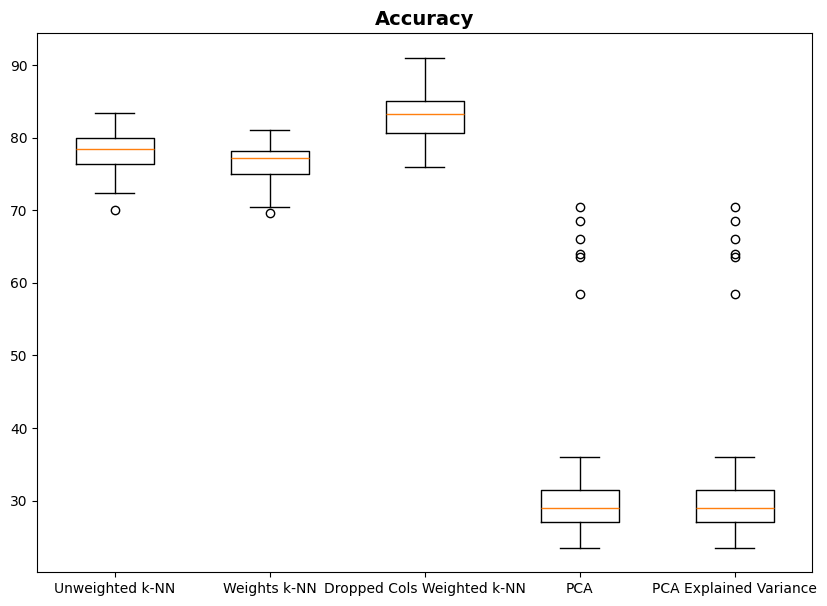

In [281]:
fig = plt.figure(figsize =(10, 7))
plt.title("Accuracy",fontsize=14, fontweight='bold')


data = [avg_acc,weight_avg_acc ,dropped_weight_avg_acc, pca_avg_acc, pca_explained_variance_acc]

x_axis = ['Unweighted k-NN', 'Weights k-NN', 'Dropped Cols Weighted k-NN', 'PCA', 'PCA Explained Variance']

# Creating plot
plt.boxplot(data, tick_labels=x_axis)

plt.savefig('Accuracy.svg')

# show plot
plt.show()

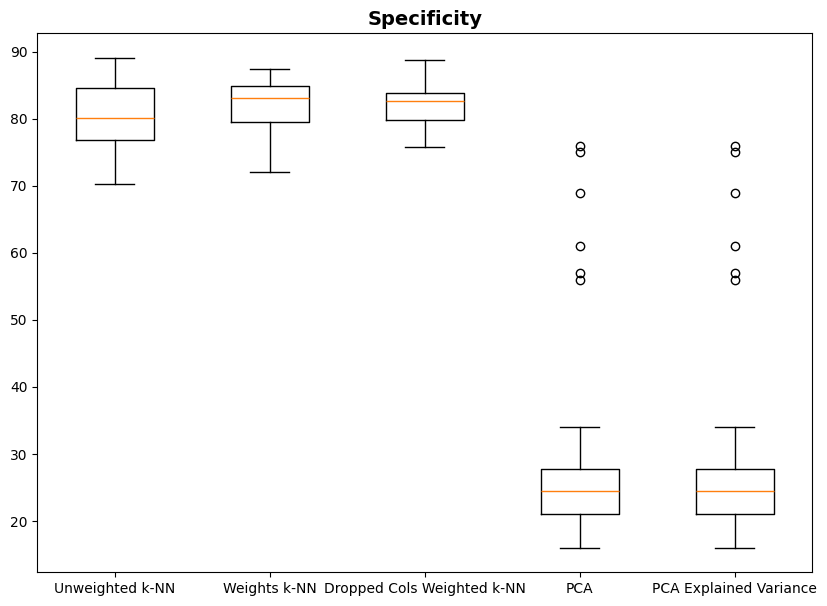

In [280]:
fig = plt.figure(figsize =(10, 7))
plt.title("Specificity",fontsize=14, fontweight='bold')


data = [avg_specificity, weight_avg_specificity, dropped_weight_avg_specificity, pca_avg_specificity, pca_explained_variance_specificity]

x_axis = ['Unweighted k-NN', 'Weights k-NN', 'Dropped Cols Weighted k-NN', 'PCA', 'PCA Explained Variance']

# Creating plot
plt.boxplot(data, tick_labels=x_axis)
plt.savefig('Specificity.svg')
# show plot
plt.show()

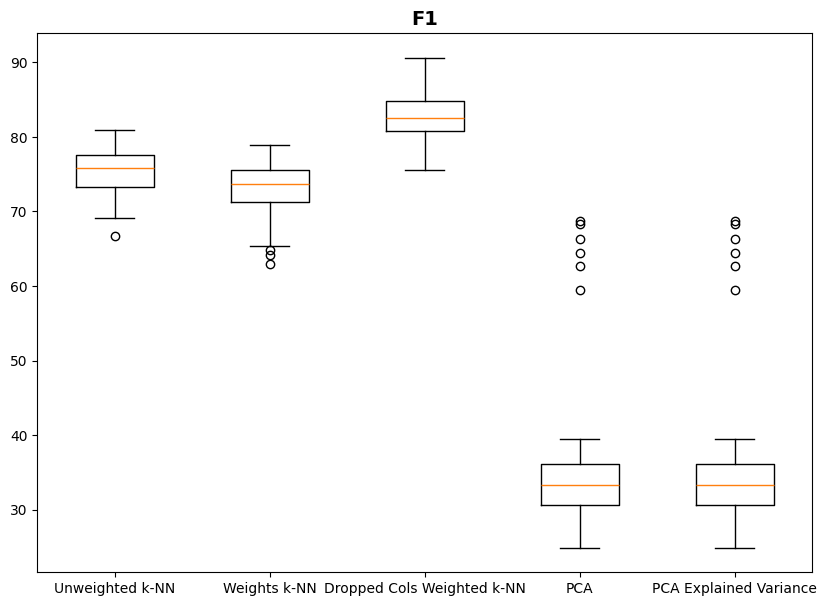

In [279]:
fig = plt.figure(figsize =(10, 7))
plt.title("F1",fontsize=14, fontweight='bold')


data = [avg_f1, weight_avg_f1, dropped_weight_avg_f1, pca_avg_f1, pca_explained_variance_f1]

x_axis = ['Unweighted k-NN', 'Weights k-NN', 'Dropped Cols Weighted k-NN', 'PCA', 'PCA Explained Variance']

# Creating plot
plt.boxplot(data, tick_labels=x_axis)

plt.savefig('F1.svg')

# show plot
plt.show()

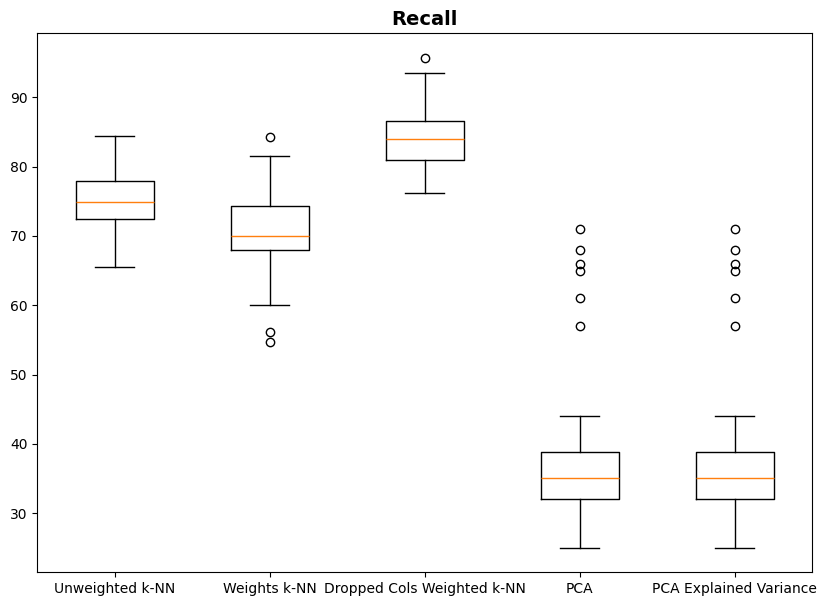

In [278]:
fig = plt.figure(figsize =(10, 7))
plt.title("Recall",fontsize=14, fontweight='bold')


data = [avg_recall,weight_avg_recall, dropped_weight_avg_recall, pca_avg_recall, pca_explained_variance_recall]

x_axis = ['Unweighted k-NN', 'Weights k-NN', 'Dropped Cols Weighted k-NN', 'PCA', 'PCA Explained Variance']

# Creating plot
plt.boxplot(data, tick_labels=x_axis)

plt.savefig('Recall.svg')

# show plot
plt.show()

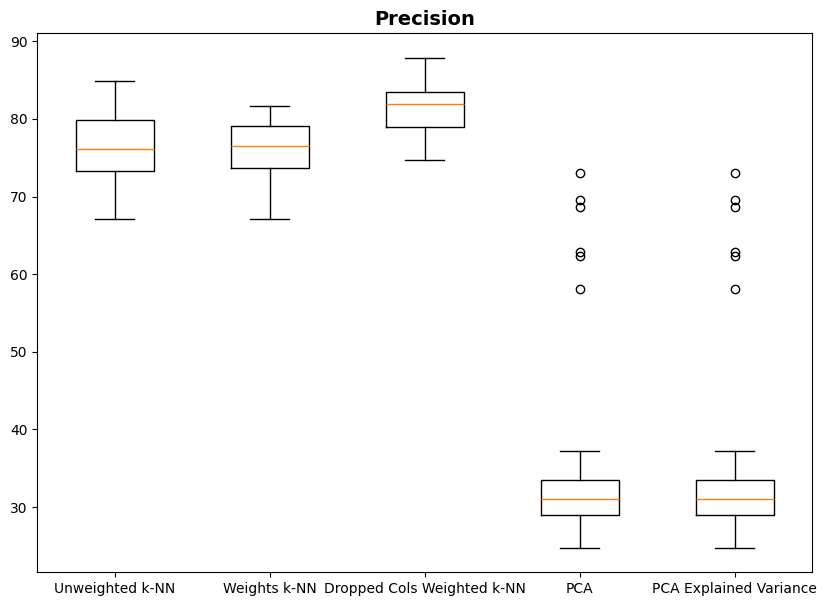

In [277]:
fig = plt.figure(figsize =(10, 7))
plt.title("Precision",fontsize=14, fontweight='bold')


data = [avg_precision, weight_avg_precision, dropped_weight_avg_precision, pca_avg_precision, pca_explained_variance_precision]

x_axis = ['Unweighted k-NN', 'Weights k-NN', 'Dropped Cols Weighted k-NN', 'PCA', 'PCA Explained Variance']

# Creating plot
plt.boxplot(data, tick_labels=x_axis)

plt.savefig('Precision.svg')

# show plot
plt.show()

<h1 style="text-align:center;">These are the Boxplots Without Regular PCA</h1>

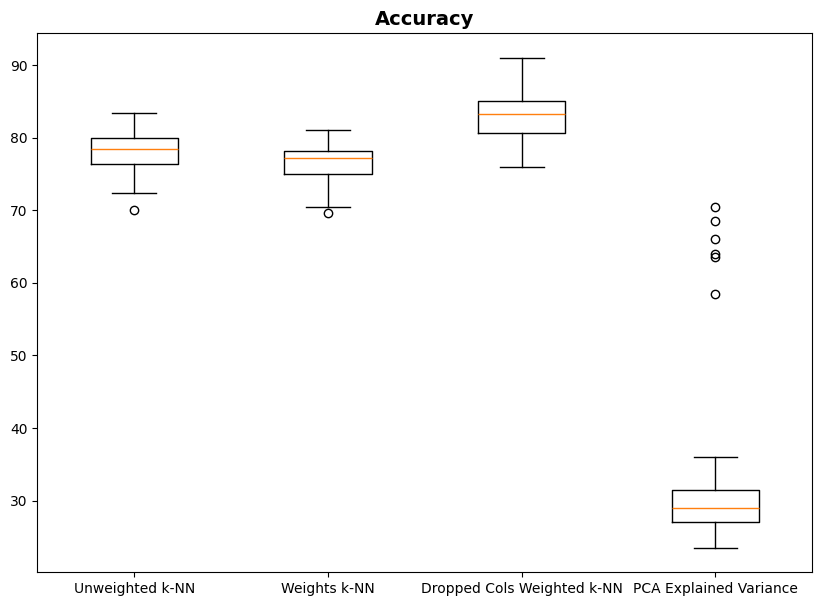

In [260]:
fig = plt.figure(figsize =(10, 7))
plt.title("Accuracy",fontsize=14, fontweight='bold')


data = [avg_acc,weight_avg_acc ,dropped_weight_avg_acc,pca_explained_variance_acc]

x_axis = ['Unweighted k-NN', 'Weights k-NN', 'Dropped Cols Weighted k-NN','PCA Explained Variance']

# Creating plot
plt.boxplot(data, tick_labels=x_axis)

# show plot
plt.show()

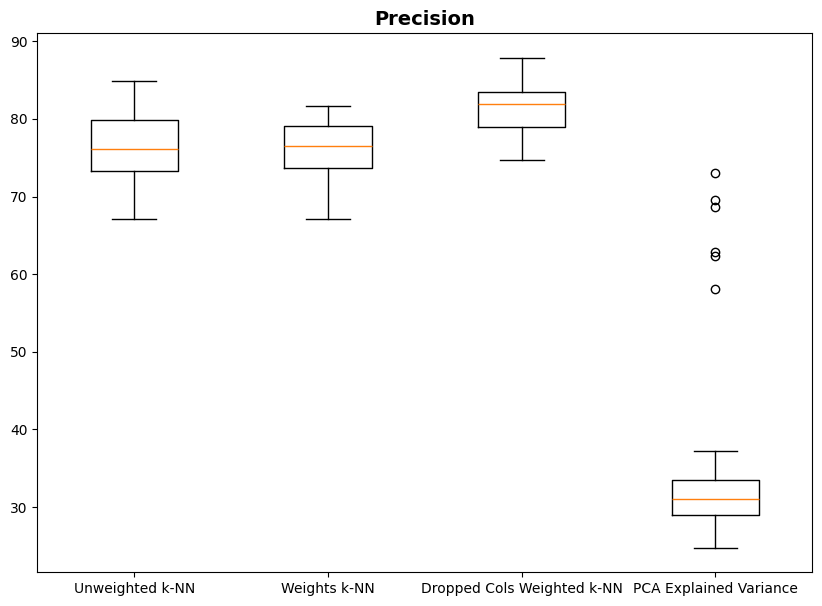

In [261]:
fig = plt.figure(figsize =(10, 7))
plt.title("Precision",fontsize=14, fontweight='bold')


data = [avg_precision,weight_avg_precision ,dropped_weight_avg_precision,pca_explained_variance_precision]

x_axis = ['Unweighted k-NN', 'Weights k-NN', 'Dropped Cols Weighted k-NN','PCA Explained Variance']

# Creating plot
plt.boxplot(data, tick_labels=x_axis)

# show plot
plt.show()

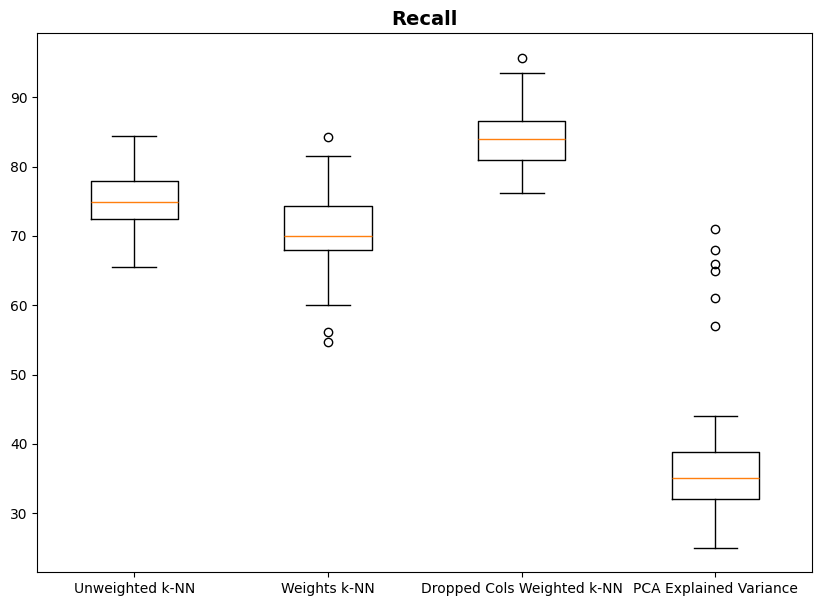

In [262]:
fig = plt.figure(figsize =(10, 7))
plt.title("Recall",fontsize=14, fontweight='bold')


data = [avg_recall,weight_avg_recall ,dropped_weight_avg_recall,pca_explained_variance_recall]

x_axis = ['Unweighted k-NN', 'Weights k-NN', 'Dropped Cols Weighted k-NN','PCA Explained Variance']

# Creating plot
plt.boxplot(data, tick_labels=x_axis)

# show plot
plt.show()

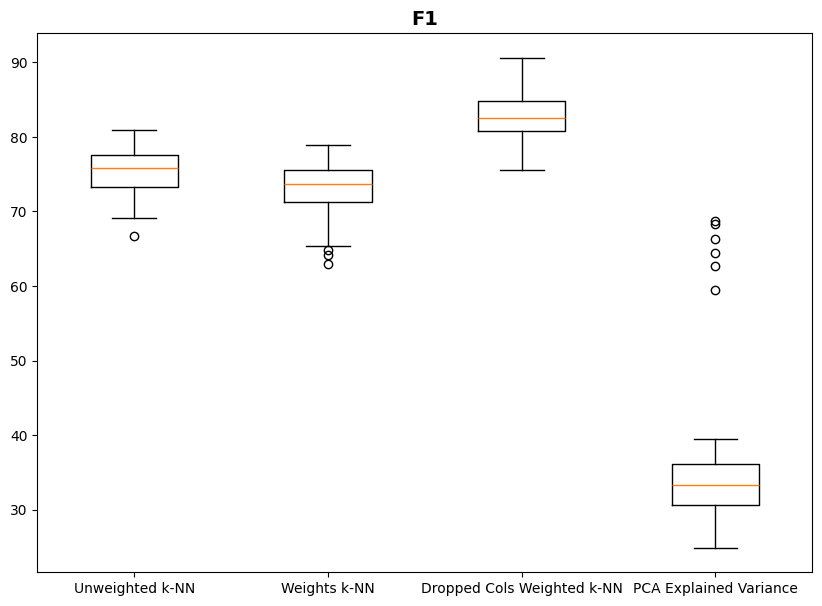

In [263]:
fig = plt.figure(figsize =(10, 7))
plt.title("F1",fontsize=14, fontweight='bold')


data = [avg_f1,weight_avg_f1 ,dropped_weight_avg_f1,pca_explained_variance_f1]

x_axis = ['Unweighted k-NN', 'Weights k-NN', 'Dropped Cols Weighted k-NN','PCA Explained Variance']

# Creating plot
plt.boxplot(data, tick_labels=x_axis)

# show plot
plt.show()

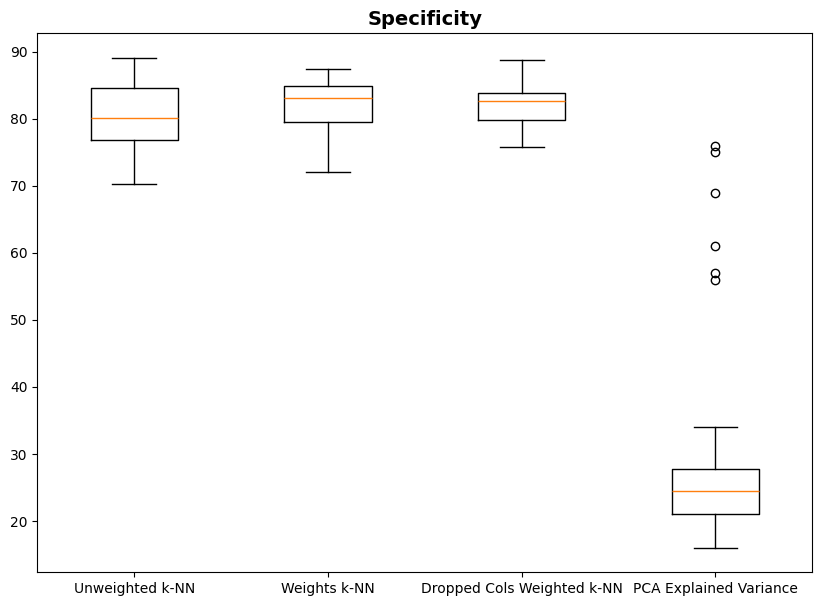

In [264]:
fig = plt.figure(figsize =(10, 7))
plt.title("Specificity",fontsize=14, fontweight='bold')


data = [avg_specificity,weight_avg_specificity ,dropped_weight_avg_specificity,pca_explained_variance_specificity]

x_axis = ['Unweighted k-NN', 'Weights k-NN', 'Dropped Cols Weighted k-NN','PCA Explained Variance']

# Creating plot
plt.boxplot(data, tick_labels=x_axis)

# show plot
plt.show()

In [179]:
min(data[0])

71.02272727272727

In [180]:
min(data[1])

69.84126984126983

In [181]:
min(data[2])

75.5

In [182]:
min(data[3])

20.0

In [183]:
max(data[0])

82.72251308900523

In [184]:
max(data[1])

82.63157894736842

In [185]:
max(data[2])

89.0

In [186]:
max(data[3])

68.5

In [187]:
pca = PCA(n_components=len(dropped_heart_X_train.columns))
pc = pca.fit_transform(dropped_heart_X_train)
pca2 = PCA(n_components=len(dropped_heart_X_test.columns))
pc2 = pca.fit_transform(dropped_heart_X_test)

In [188]:
pc

array([[ 1.65352334,  0.07922232, -1.30340254, ..., -0.14691346,
        -0.27983351,  0.27974423],
       [ 2.03956888, -2.26705436,  0.98278868, ...,  1.29495008,
        -0.75140021,  0.04805232],
       [ 2.59999724, -0.4971334 ,  0.35380369, ...,  1.00596538,
         0.07866271,  0.10882627],
       ...,
       [ 0.68561718,  1.77552432, -1.3948552 , ...,  0.64541561,
         0.29404991, -1.4567114 ],
       [-1.49540357,  0.01667615,  0.03324728, ..., -0.37735956,
        -0.91684507,  0.27931975],
       [-2.33605962, -0.17515143, -0.12204218, ...,  0.1191305 ,
         0.08786872,  0.06739689]])

In [189]:
dropped_heart_X_train.head()

,cp,thalach,exang,oldpeak,slope,ca,thal
0,-0.164013,-0.810726,1.433497,0.638393,0.642696,-0.720760,1.170601
1,0.872408,-0.767137,1.433497,0.638393,-0.974938,2.474249,1.170601
2,0.872408,-0.331247,1.433497,1.495935,0.642696,1.409246,1.170601
3,0.872408,-1.028671,1.433497,1.495935,0.642696,0.344243,1.170601
4,0.872408,0.453355,-0.695246,2.181970,2.260330,1.409246,-0.892713


In [190]:
pc2

array([[ 1.65352334,  0.07922232, -1.30340254, ..., -0.14691346,
        -0.27983351,  0.27974423],
       [ 2.03956888, -2.26705436,  0.98278868, ...,  1.29495008,
        -0.75140021,  0.04805232],
       [ 2.59999724, -0.4971334 ,  0.35380369, ...,  1.00596538,
         0.07866271,  0.10882627],
       ...,
       [ 0.68561718,  1.77552432, -1.3948552 , ...,  0.64541561,
         0.29404991, -1.4567114 ],
       [-1.49540357,  0.01667615,  0.03324728, ..., -0.37735956,
        -0.91684507,  0.27931975],
       [-2.33605962, -0.17515143, -0.12204218, ...,  0.1191305 ,
         0.08786872,  0.06739689]])

In [191]:
df_pca = pd.DataFrame(data = pc, columns = ['principal component 1', 'principal component 2', 'principal component 3','principal component 4', 'principal component 5', 'principal component 6','principal component 7'])
df_pca2 = pd.DataFrame(data = pc2, columns = ['principal component 1', 'principal component 2', 'principal component 3','principal component 4', 'principal component 5', 'principal component 6','principal component 7'])


In [192]:
final_train_pca_df = pd.concat([df_pca, heart_y_train[['num']]], axis = 1)
final_test_pca_df = pd.concat([df_pca2, heart_y_train[['num']]], axis = 1)

In [193]:
final_train_pca_df.head()

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,principal component 6,principal component 7,num
0,1.653523,0.079222,-1.303403,-0.645254,-0.146913,-0.279834,0.279744,1.0
1,2.039569,-2.267054,0.982789,0.170311,1.294950,-0.751400,0.048052,1.0
2,2.599997,-0.497133,0.353804,0.410766,1.005965,0.078663,0.108826,1.0
3,2.621426,-0.231989,-0.362355,0.353953,0.110740,-0.354351,0.320560,1.0
4,1.456863,2.137880,1.925374,1.403033,0.723353,0.367976,-0.680950,1.0


In [194]:
dropped_heart_X_train.head()

,cp,thalach,exang,oldpeak,slope,ca,thal
0,-0.164013,-0.810726,1.433497,0.638393,0.642696,-0.720760,1.170601
1,0.872408,-0.767137,1.433497,0.638393,-0.974938,2.474249,1.170601
2,0.872408,-0.331247,1.433497,1.495935,0.642696,1.409246,1.170601
3,0.872408,-1.028671,1.433497,1.495935,0.642696,0.344243,1.170601
4,0.872408,0.453355,-0.695246,2.181970,2.260330,1.409246,-0.892713
